# Прогнозирование стоимости квартир в Москве 

In [106]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

import math

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

# Загрузка данных

In [107]:
df = pd.read_csv("flats_moscow.csv")

In [108]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2040 entries, 0 to 2039
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2040 non-null   int64  
 1   price       2040 non-null   int64  
 2   totsp       2040 non-null   int64  
 3   livesp      2040 non-null   int64  
 4   kitsp       2040 non-null   float64
 5   dist        2040 non-null   float64
 6   metrdist    2040 non-null   int64  
 7   walk        2040 non-null   int64  
 8   brick       2040 non-null   int64  
 9   floor       2040 non-null   int64  
 10  code        2040 non-null   int64  
dtypes: float64(2), int64(9)
memory usage: 175.4 KB


,Unnamed: 0,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
0,1,81,58,40,6.0,12.5,7,1,1,1,3
1,2,75,44,28,6.0,13.5,7,1,0,1,6
2,3,128,70,42,6.0,14.5,3,1,1,1,3
3,4,95,61,37,6.0,13.5,7,1,0,1,1
4,5,330,104,60,11.0,10.5,7,0,1,1,3


In [109]:
# Unnamed ? 
df.drop('Unnamed: 0', axis=1, inplace=True)

# Описание полей

price: цена квартиры в 1000$ / the price of a flat in 1000;

totsp: общая площадь квартиры, кв.м. / total square of a flat, m2;

livesp: жилая площадь квартиры, кв.м. / living square of a flat, m2;

kitsp: площадь кухни, кв.м. / kitchen square, m2;

dist: расстояние от центра в км. / distance to the city center, km;

metrdist: расстояние до метро в минутах / distance to the nearest metro station, min;

walk: 1 – пешком от метро, 0 – на транспорте / 1 - walk to metro, 0 - using transport;

brick: 1 – кирпичный, монолит ж/б, 0 – другой / 1 - brick, monolithic house, 0 - anothers;

floor: 1 – этаж кроме первого и последнего, 0 – иначе / 0 - the first or the last floor, 1 - anothers;

code: число от 1 до 8, обозначающее район города / number from 1 to 8 of the city area:

    1. Север, около Калужско-Рижской линии метро / North of the city, around Kaluzhsko-Rizhskaya metro line;
    
    2. Север, около Серпуховско-Тимирязевской линии метро / North of the city, around Serpukhovsko-Timiryazevskaya metro line;
    
    3. Северо-запад, около Замоскворецкой линиии метро / North-West, around Zamoskvoretskaya metro line;
    
    4. Северо-запад, около Таганско-Краснопресненской линиии метро / North-West, around Tagansko-Krasnopresnenskaya metro line;
    
    5. Юго-восток, около Люблинской линиии метро / South-East, around Lyublinskaya metro line;
    
    6. Юго-восток, около Таганско-Краснопресненской линиии метро / South-East, around Tagansko-Krasnopresnenskaya metro line;
    
    7. Восток, около Калининской линиии метро / East, around Kalininskaya metro line;
    
    8. Восток, около Арбатско-Покровской линиии метро / East, around Arbatsko-Pokrovskaya metro line.

# Анализ данных

In [110]:
num_cols = ['price','totsp','livesp','kitsp','dist', 'metrdist'] 
cat_cols = ['code'] 
bin_cols = ['walk','brick','floor'] 

# Численные столбцы

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'totsp'}>],
       [<AxesSubplot:title={'center':'livesp'}>,
        <AxesSubplot:title={'center':'kitsp'}>],
       [<AxesSubplot:title={'center':'dist'}>,
        <AxesSubplot:title={'center':'metrdist'}>]], dtype=object)

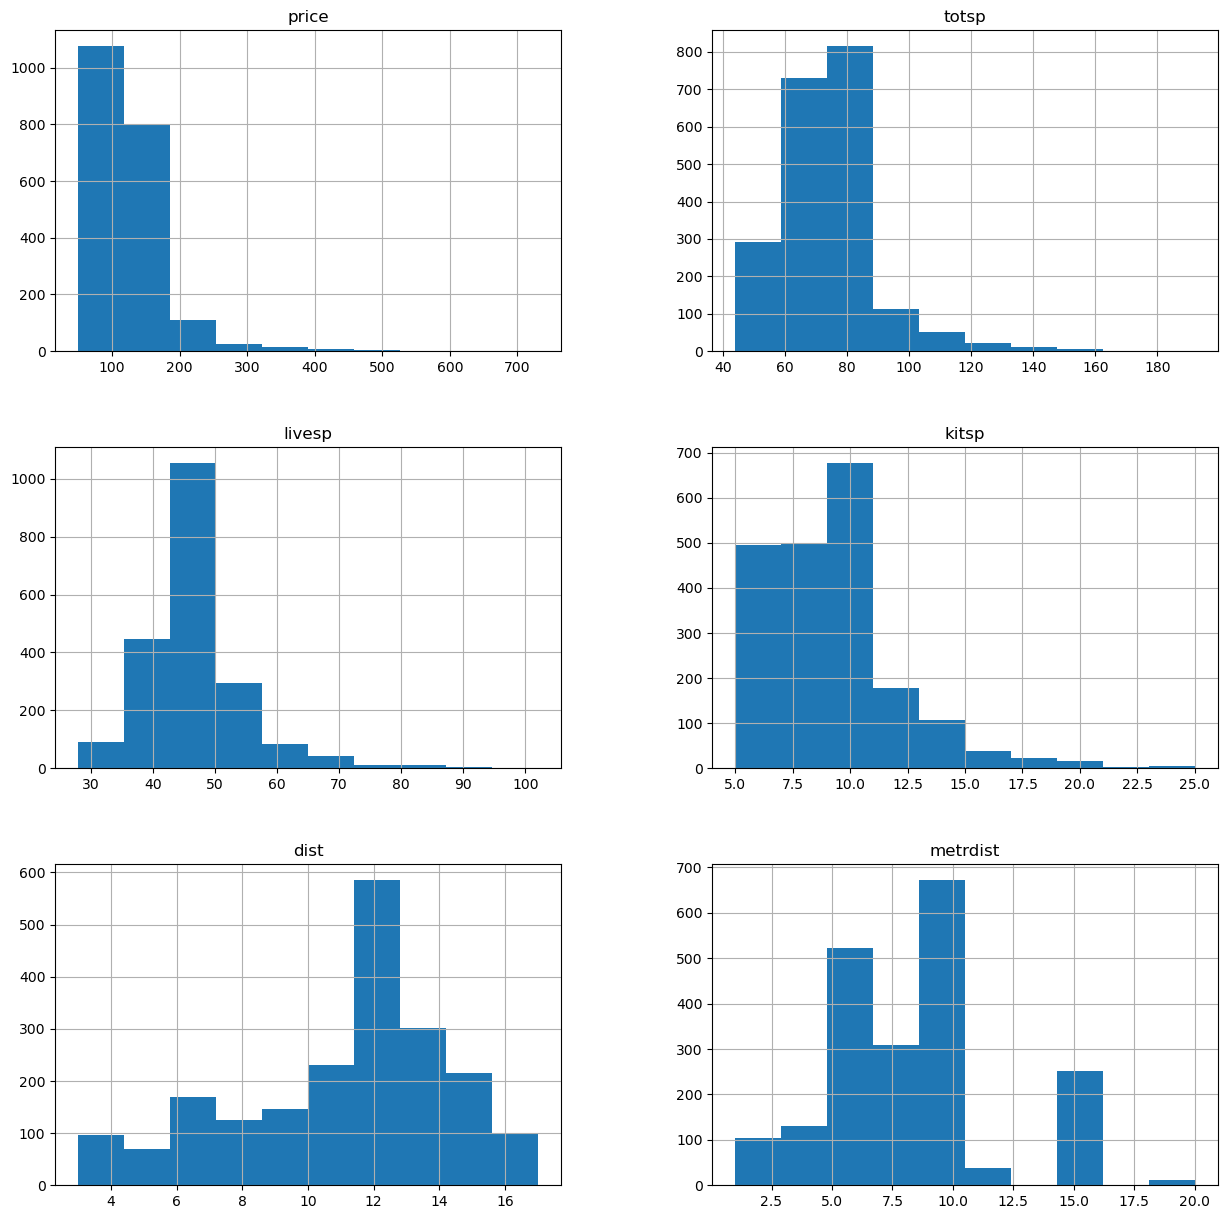

In [111]:
df[num_cols].hist(figsize=(15,15))

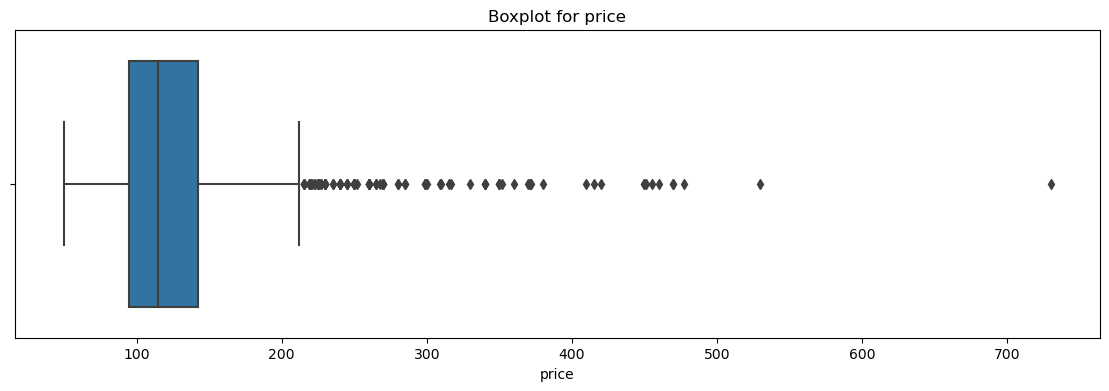

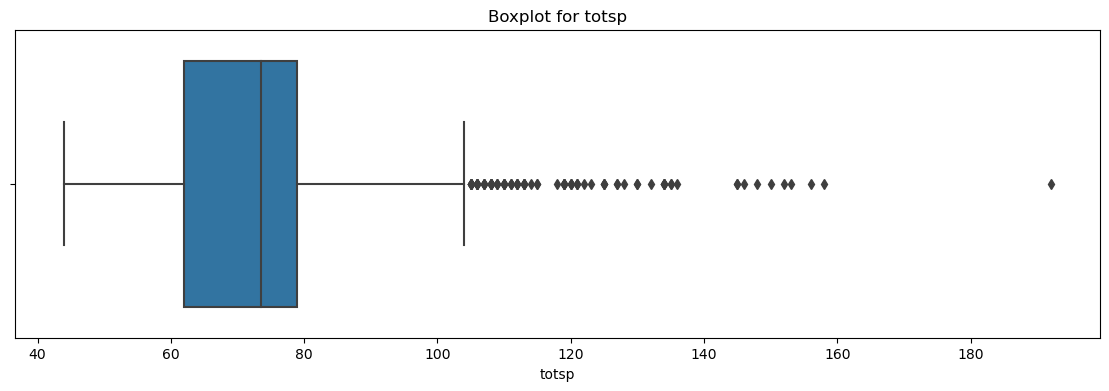

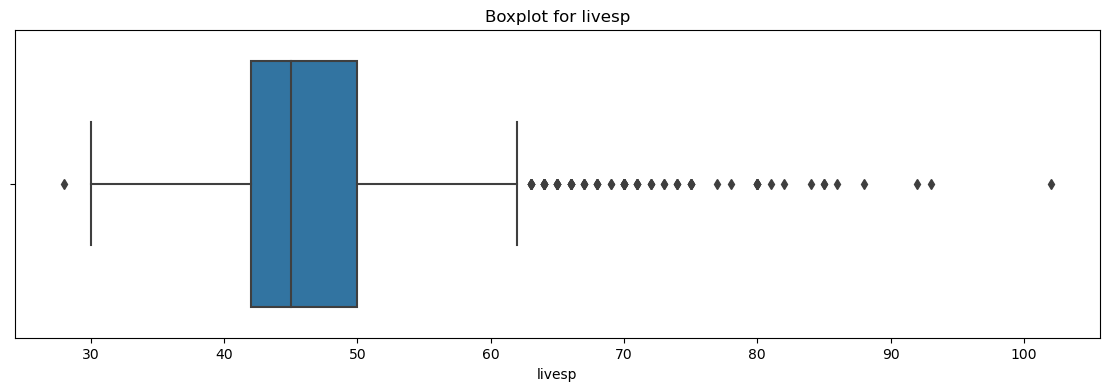

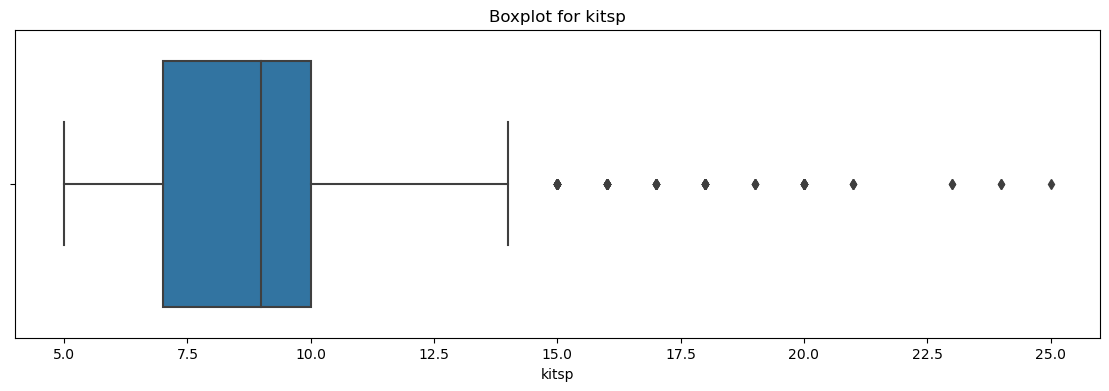

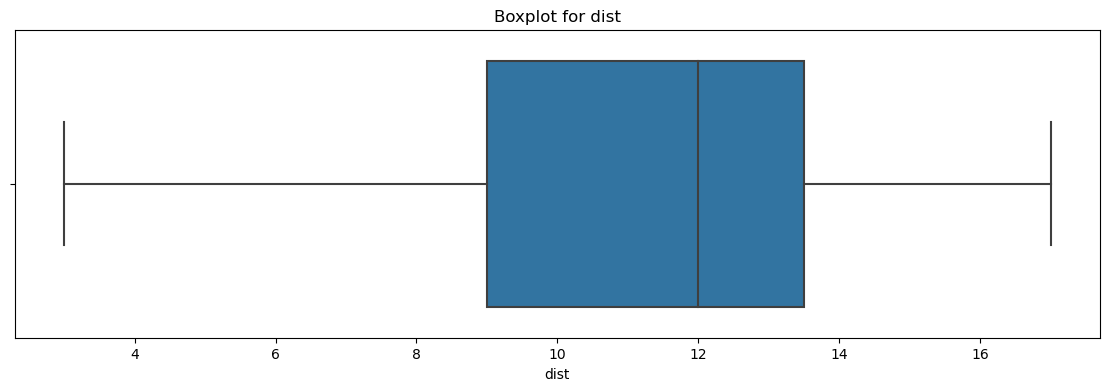

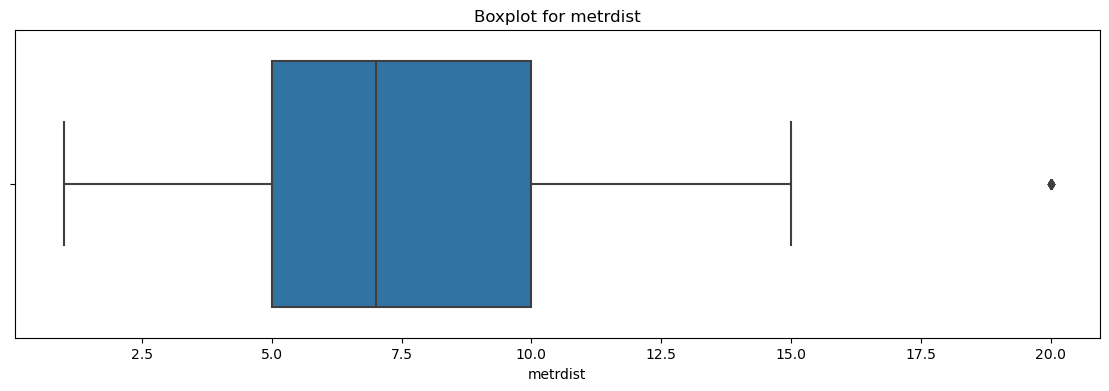

In [112]:
def boxplot(col):
    fig, axes = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=col, data=df)
    axes.set_title('Boxplot for ' + col)
    plt.show()
for col in num_cols:
    boxplot(col)

<AxesSubplot:xlabel='totsp', ylabel='price'>

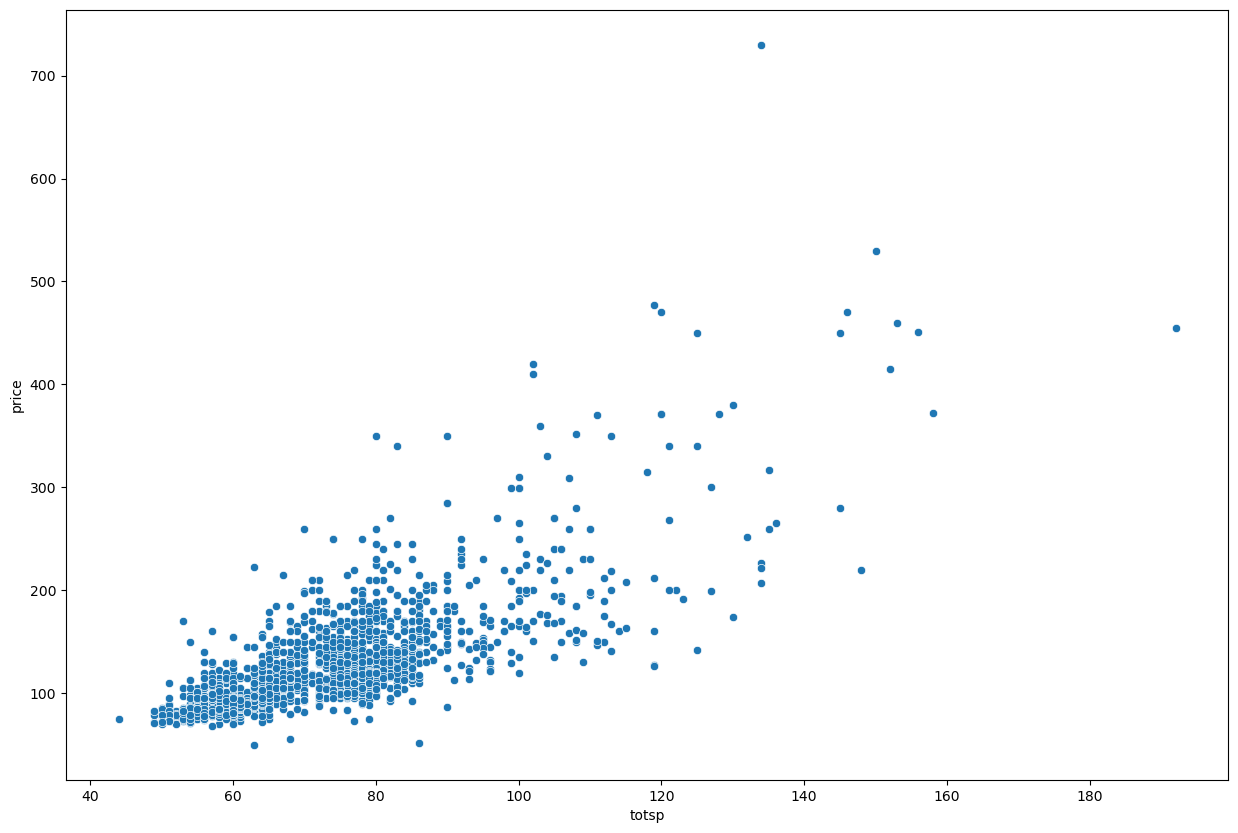

In [113]:
plt.figure(figsize=(15,10))
sns.scatterplot(x=df.totsp, y=df.price)

<AxesSubplot:xlabel='kitsp', ylabel='price'>

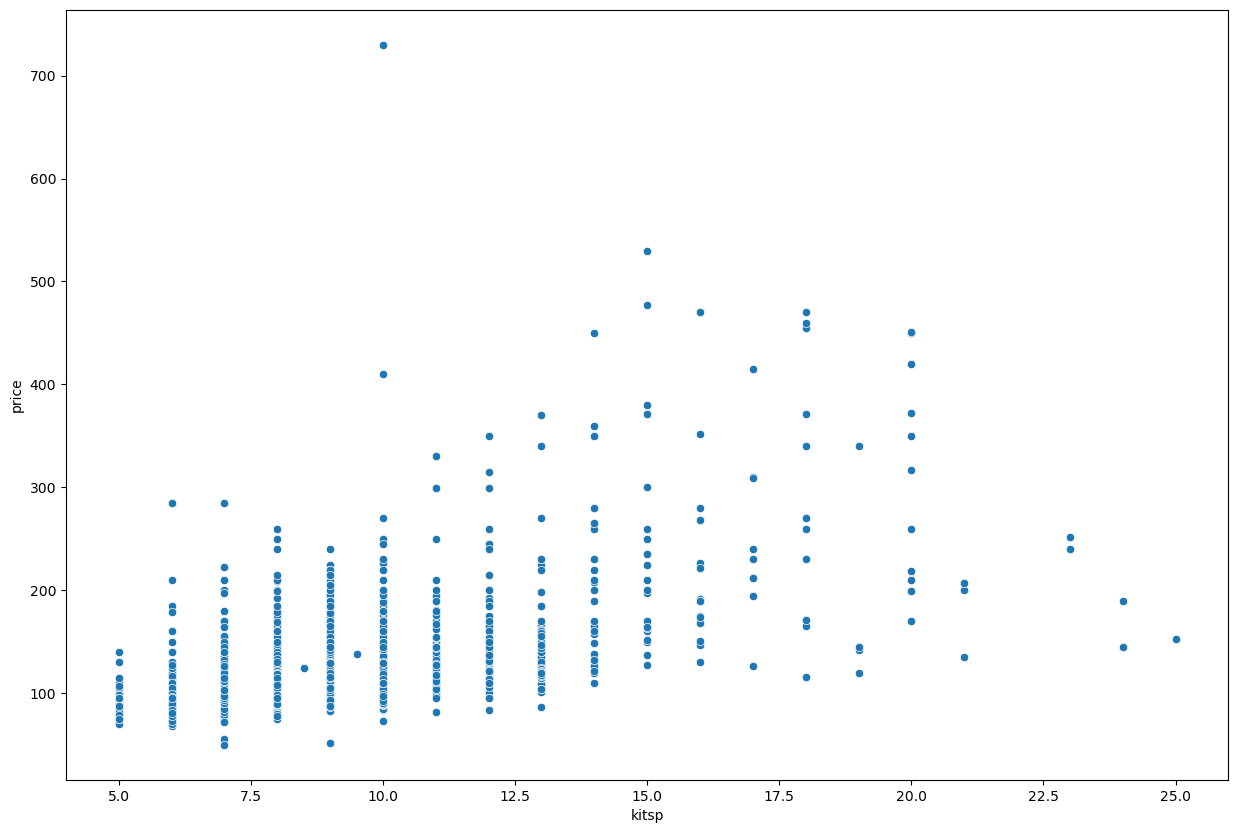

In [114]:
plt.figure(figsize=(15,10))
sns.scatterplot(x=df.kitsp, y=df.price)

Зависимость от цены кухни небольшая, даже, удивительно несколько домов с особенно большими кухнями, стоят дешевле аналогов, возможно потому что это пространство "ворует" площадь остальных комнат

<AxesSubplot:xlabel='totsp', ylabel='kitsp'>

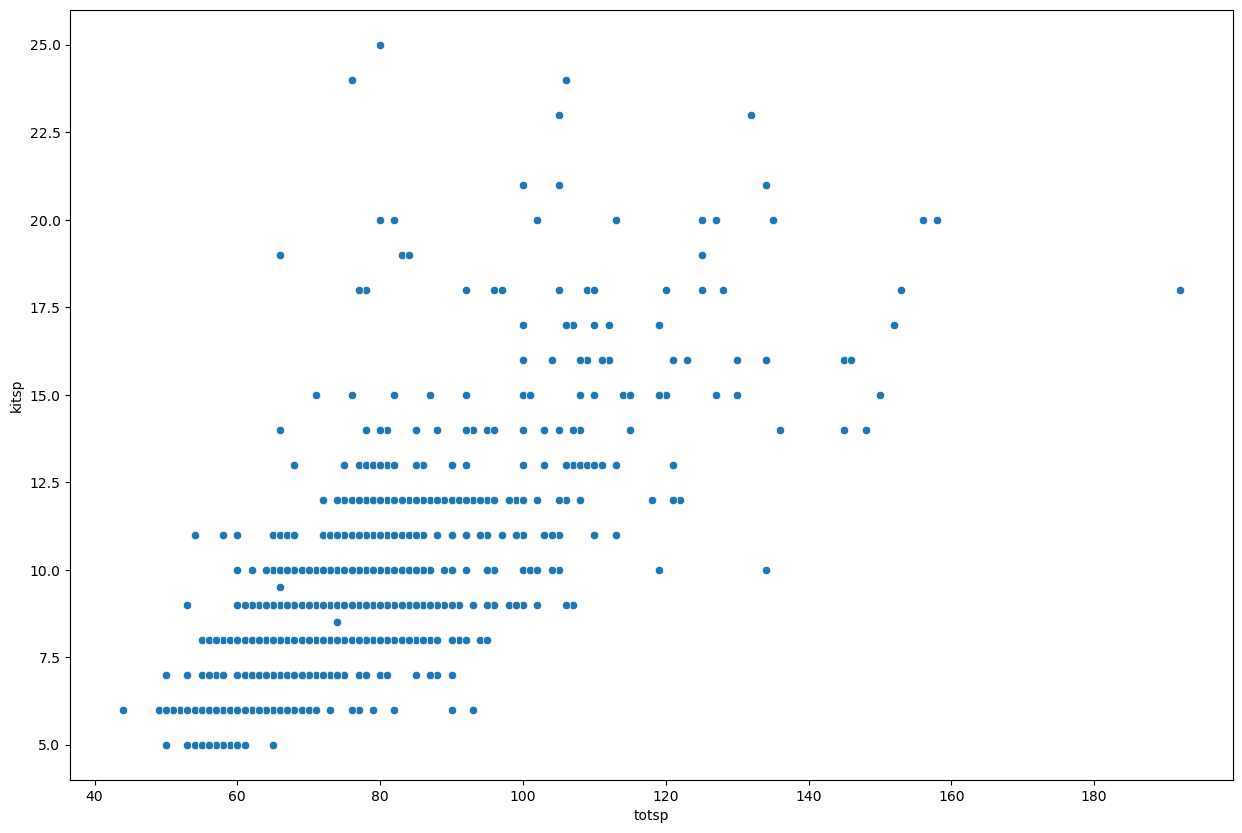

In [115]:
plt.figure(figsize=(15,10))
sns.scatterplot(x=df.totsp, y=df.kitsp)

Пара выбывшихся точек ближе к верхнему левому углу подтверждают нашу теорию

In [116]:
df.query('kitsp > 22')

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
520,190,106,58,24.0,9.0,5,0,0,1,4
667,240,105,55,23.0,10.0,5,1,0,1,6
1119,252,132,74,23.0,12.5,3,1,1,0,3
1126,153,80,40,25.0,10.5,10,0,0,1,3
1684,145,76,44,24.0,12.7,2,1,0,0,5


<AxesSubplot:xlabel='livesp', ylabel='price'>

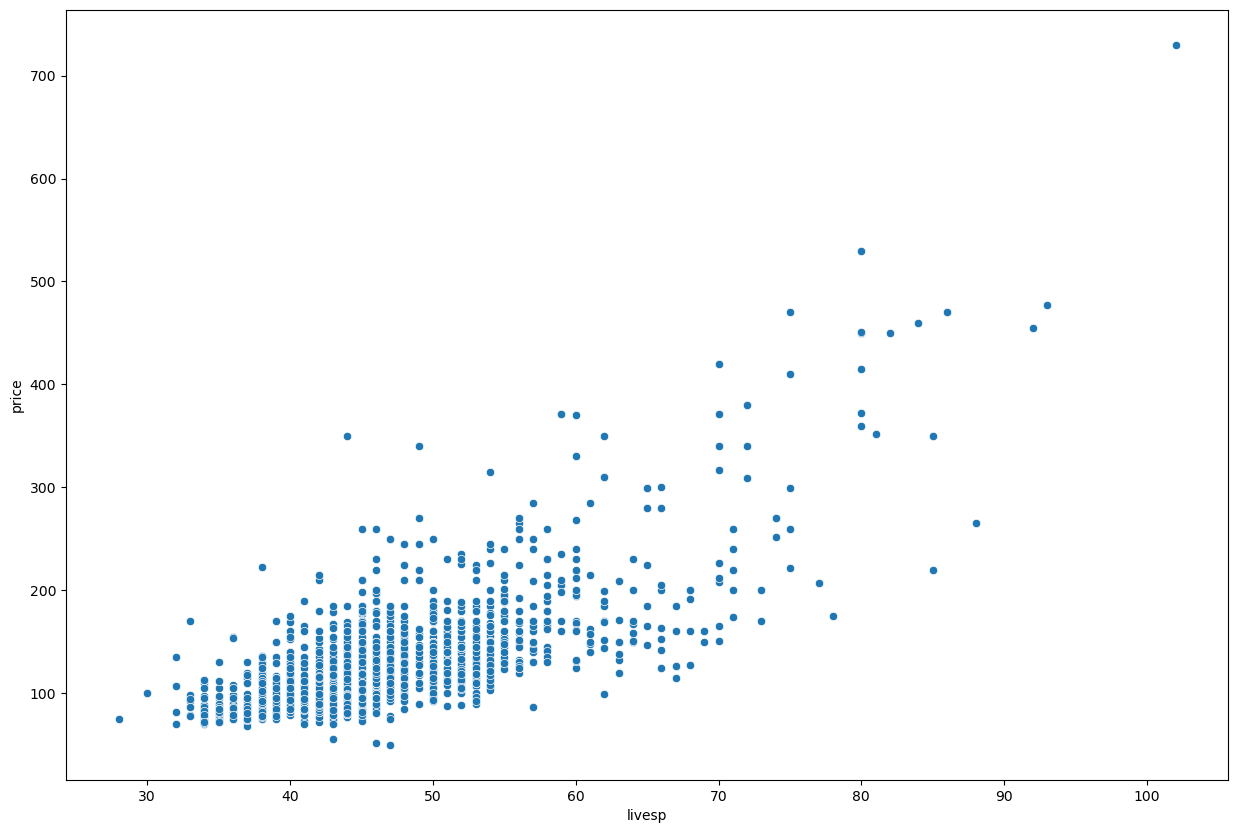

In [117]:
plt.figure(figsize=(15,10))
sns.scatterplot(x=df.livesp, y=df.price)

Жилая площадь показывает почти такую же линейную зависимость как и общая площадь

<AxesSubplot:xlabel='dist', ylabel='price'>

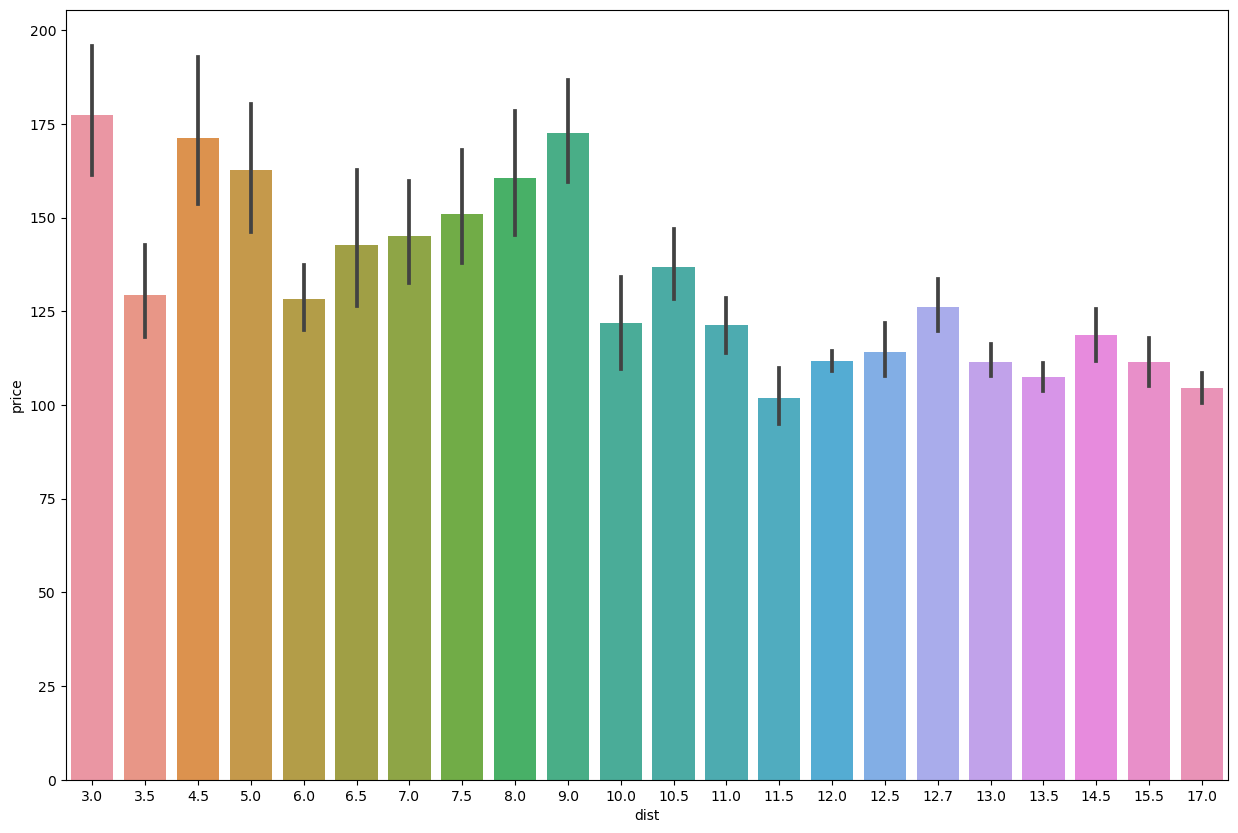

In [118]:
plt.figure(figsize=(15,10))
sns.barplot(x=df.dist, y=df.price)

Видим, что после 9 км от центра явно снижается средняя цена на квартиры, попробуем выделить это разделение в отдельный признак close_to_center, значение 0 которого, будет означать, что квартира дальше чем 9 км от центра, 
1 - близкие к центру квартиры (<= 9 км)

<AxesSubplot:xlabel='dist', ylabel='totsp'>

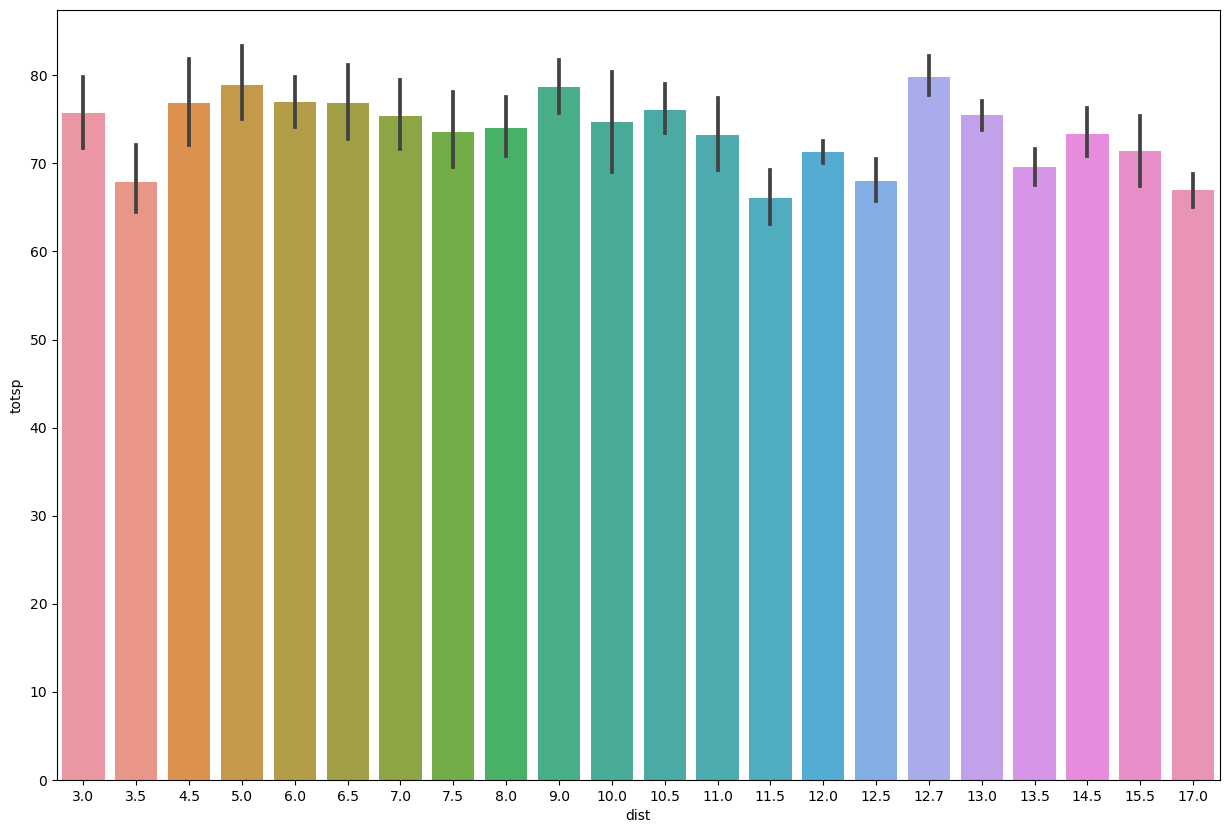

In [119]:
plt.figure(figsize=(15,10))
sns.barplot(x=df.dist, y=df.totsp)

При этом площади квартир не зависят от расстояния от центра, так что нельзя просто сказать, что в центре большие по размеру "люксовые" апартаменты

Расстояние от центра и от метро показывает лишь только, что люди не хотят платить много за квартиры "слишком" далеко от центра/метро (>16-20 м), но в остальном другие параметры берут предпочтение

<AxesSubplot:xlabel='metrdist', ylabel='price'>

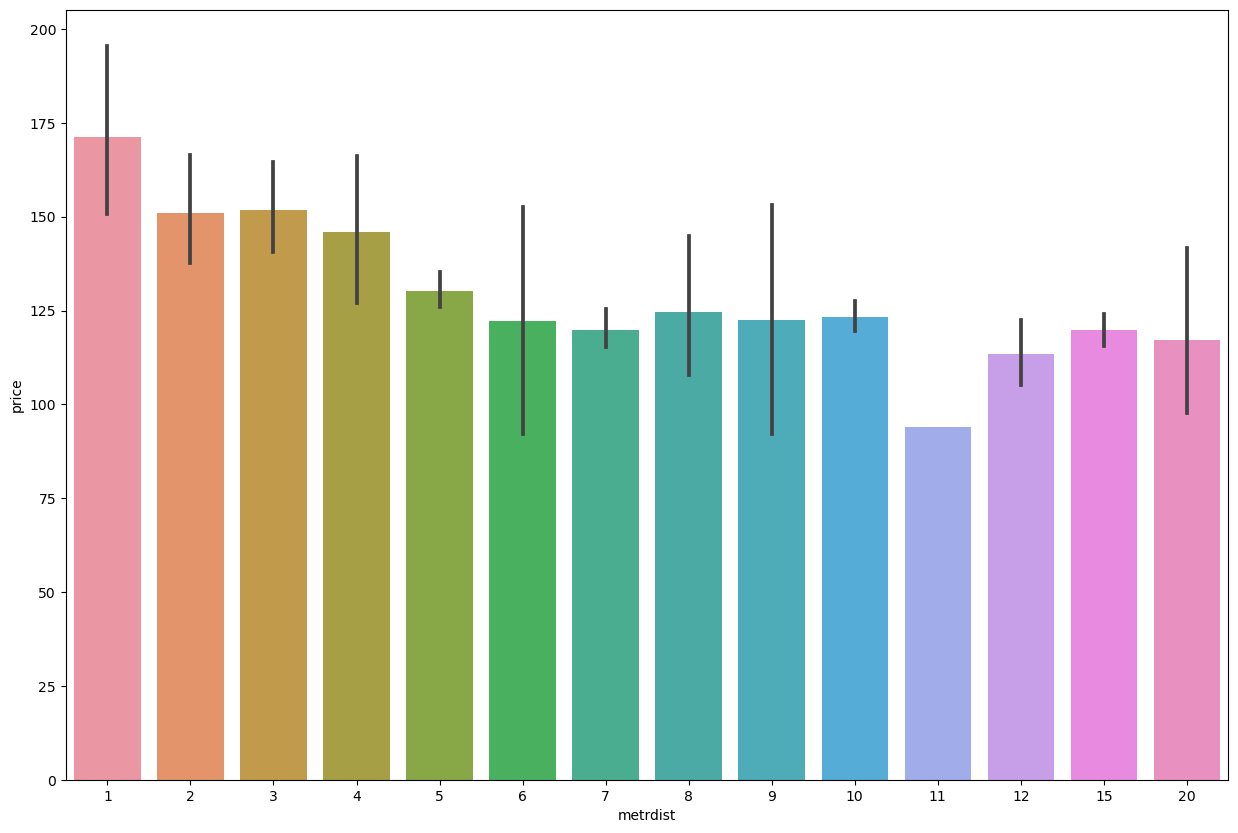

In [120]:
plt.figure(figsize=(15,10))
sns.barplot(x=df.metrdist, y=df.price)

В расстоянии от метро четкой зависимости не видно, выделяется лишь первый столбец как выше среднего, и 11, в котором судя по всему только одна квартира

In [121]:
df.query('metrdist == 11')

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
1458,94,64,38,9.0,12.0,11,0,0,1,7


In [122]:
df.query('metrdist == 1')

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
17,175,79,50,9.0,4.5,1,1,1,0,8
53,140,99,51,12.0,10.5,1,1,0,0,7
183,270,105,74,18.0,5.0,1,1,1,1,4
202,120,63,43,9.0,12.0,1,1,0,0,8
237,150,78,44,8.0,13.5,1,1,0,1,1
262,195,110,55,11.0,12.0,1,1,1,1,7
272,105,66,48,8.0,12.0,1,1,0,0,5
502,80,56,37,6.0,10.0,1,1,0,0,6
557,145,73,45,7.0,9.0,1,1,1,1,4
575,225,92,48,13.0,9.0,1,1,1,1,4


# Категориальные столбцы

<AxesSubplot:>

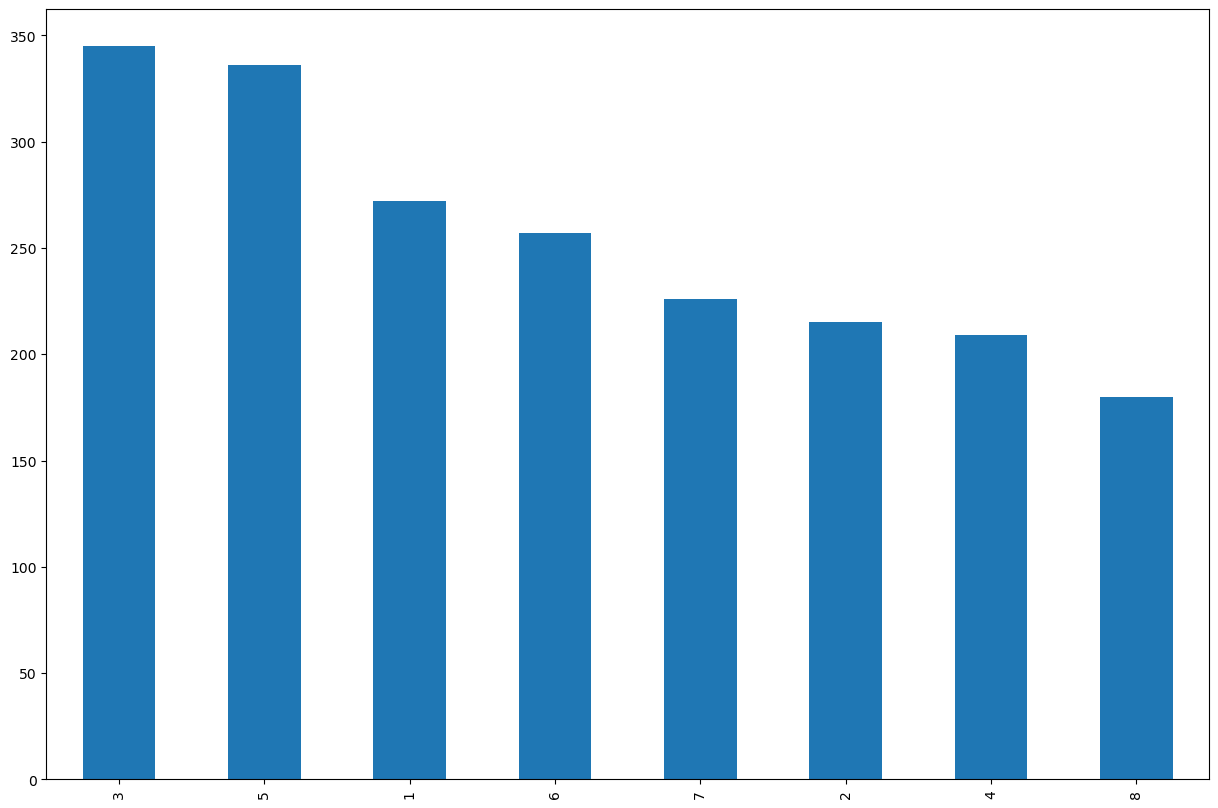

In [123]:
plt.figure(figsize=(15,10))
df['code'].value_counts().plot.bar()

<AxesSubplot:xlabel='code', ylabel='price'>

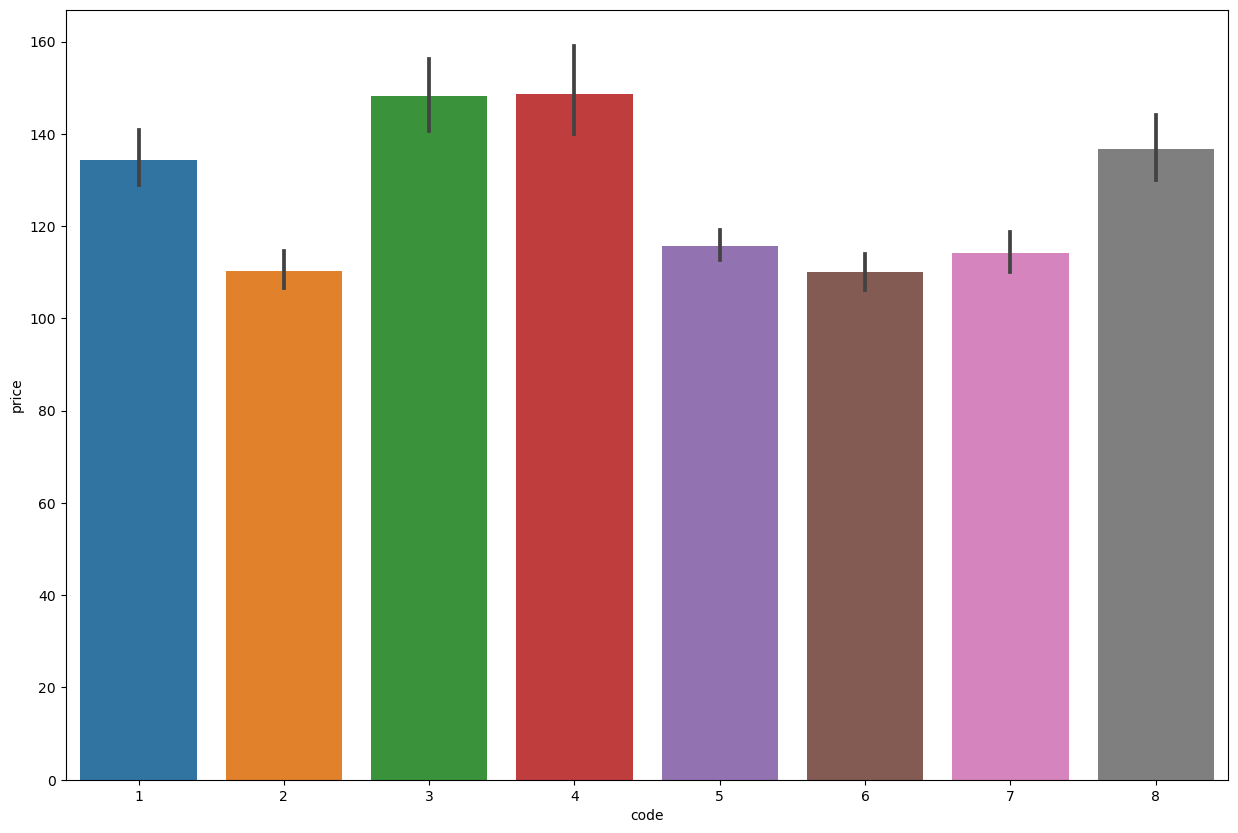

In [124]:
plt.figure(figsize=(15,10))
sns.barplot(x=df.code, y=df.price)

Из районов можно выделить 4 "хороших" - 1, 3, 4, 8. Сделаем это отдельным признаком и посмотрим на результаты

# Бинарные столбцы

<AxesSubplot:xlabel='walk', ylabel='count'>

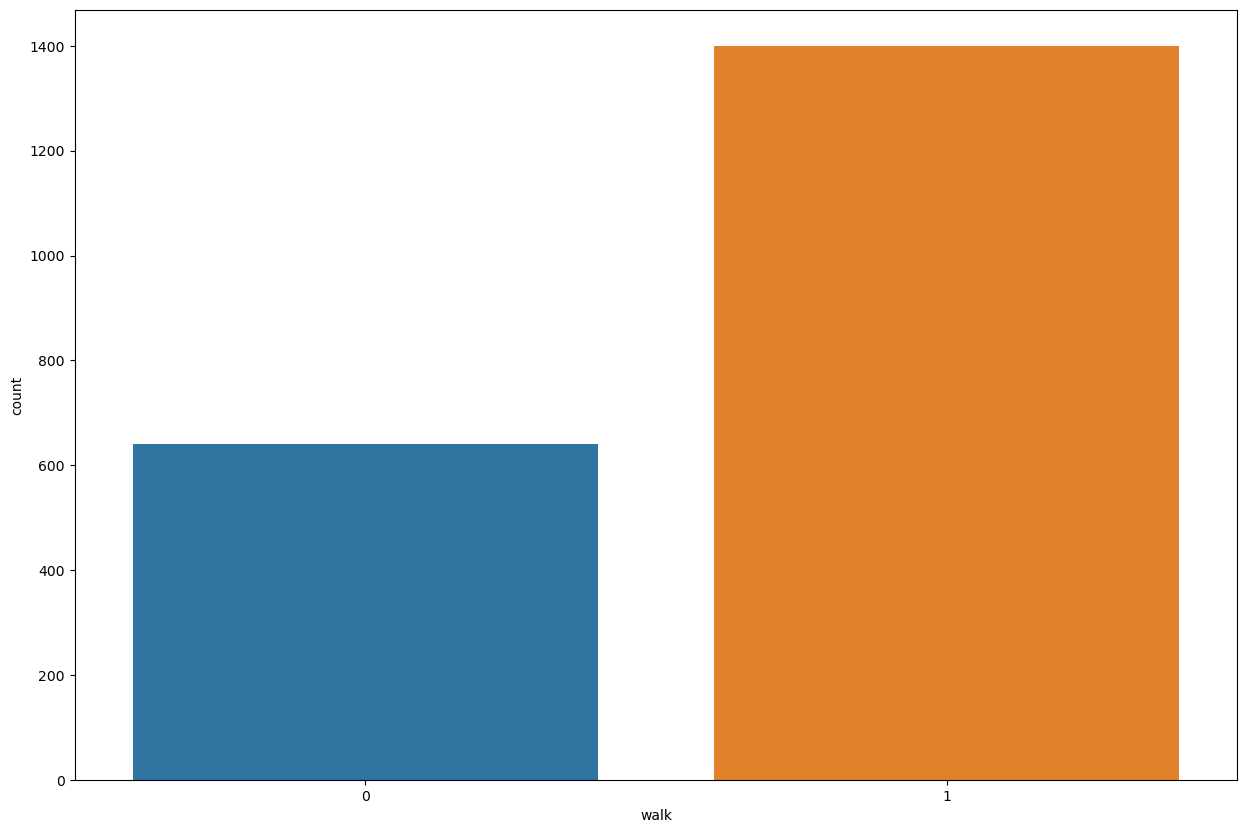

In [125]:
plt.figure(figsize=(15,10))
sns.countplot(data=df, x='walk')

<AxesSubplot:xlabel='walk', ylabel='price'>

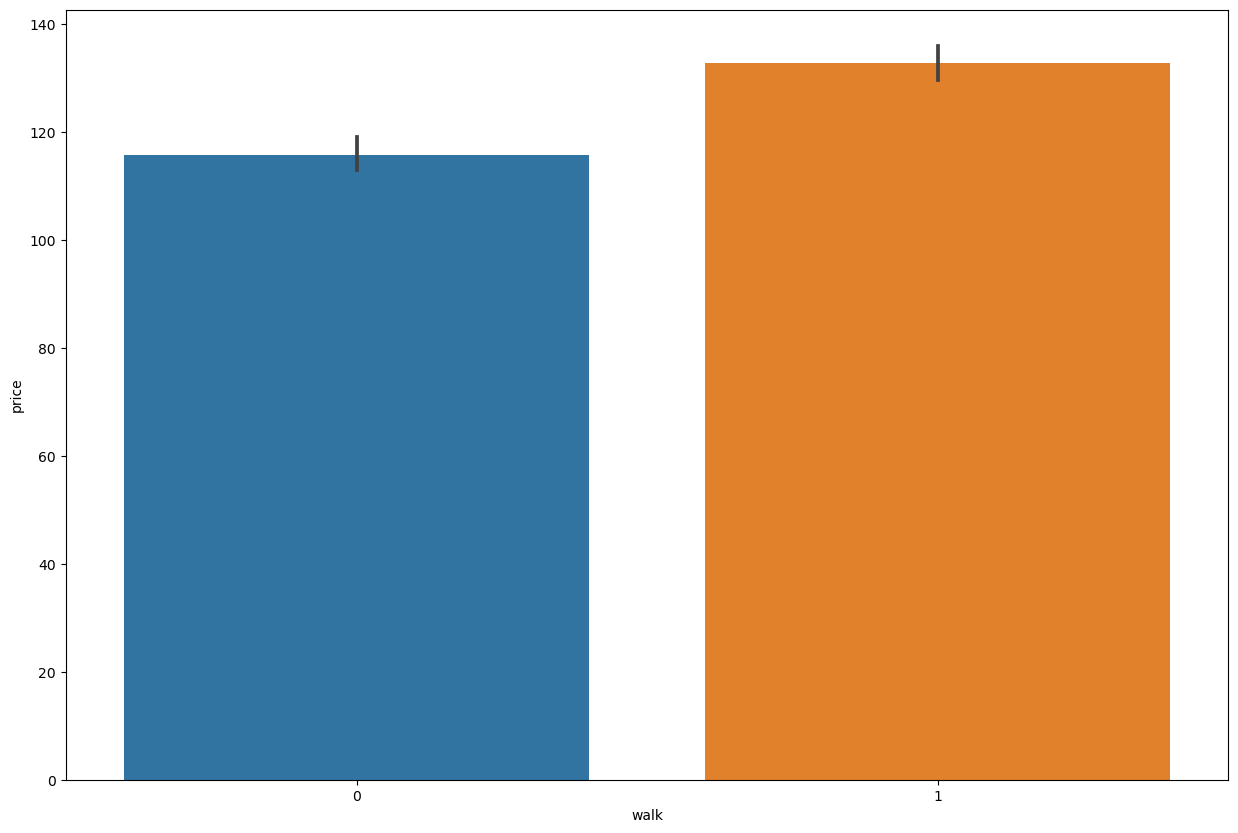

In [126]:
plt.figure(figsize=(15,10))
sns.barplot(x=df.walk, y=df.price)

<AxesSubplot:xlabel='walk', ylabel='totsp'>

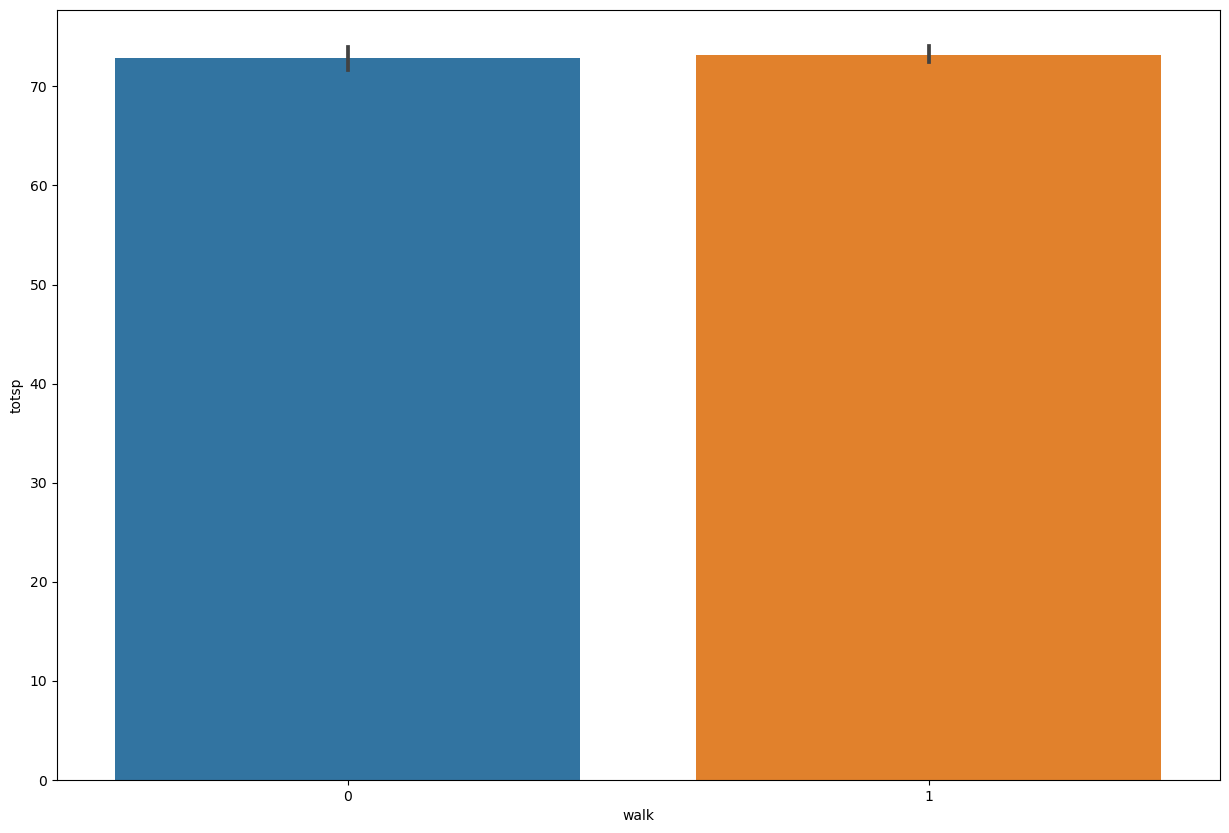

In [127]:
plt.figure(figsize=(15,10))
sns.barplot(x=df.walk, y=df.totsp)

При этом явно видно, что возможность добраться до метро добавляет стоимости, то есть не столь важна удаленность, сколько возможность

<AxesSubplot:xlabel='brick', ylabel='count'>

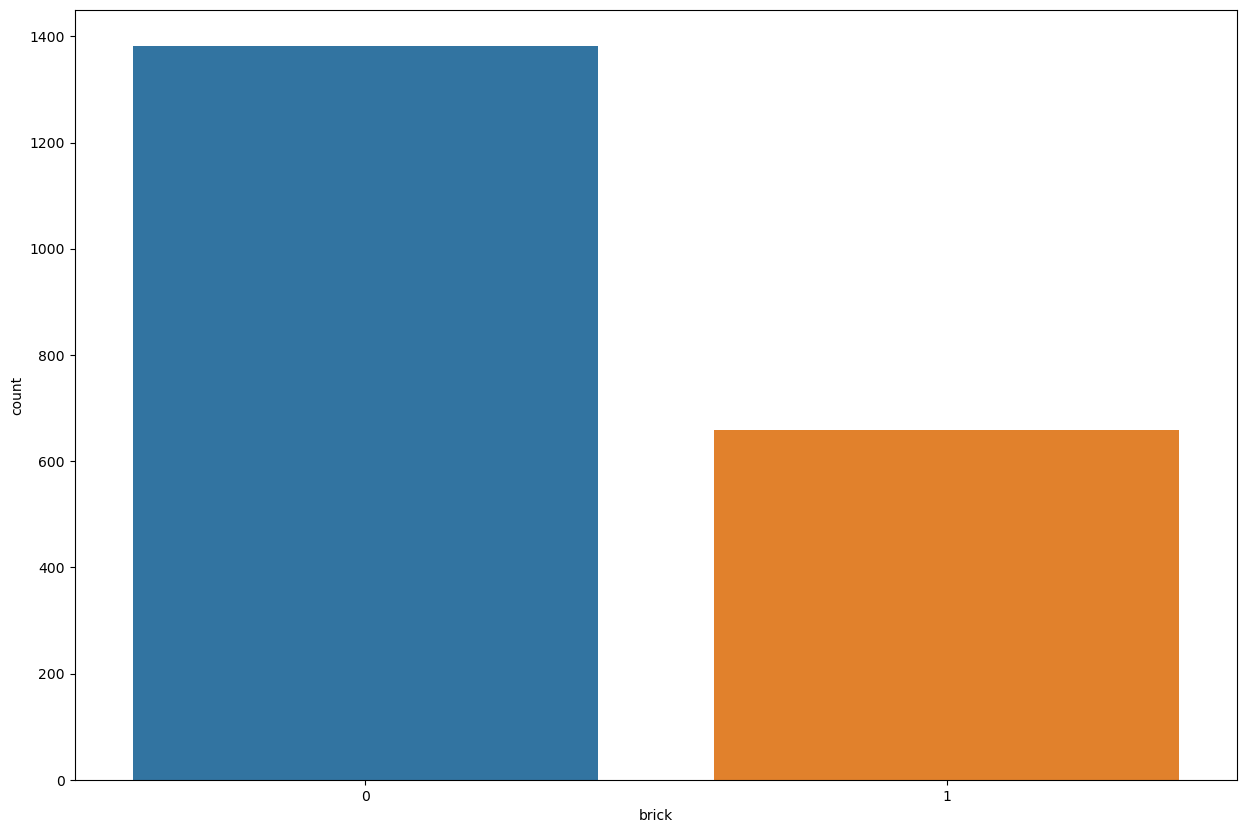

In [128]:
plt.figure(figsize=(15,10))
sns.countplot(data=df, x='brick')

<AxesSubplot:xlabel='brick', ylabel='price'>

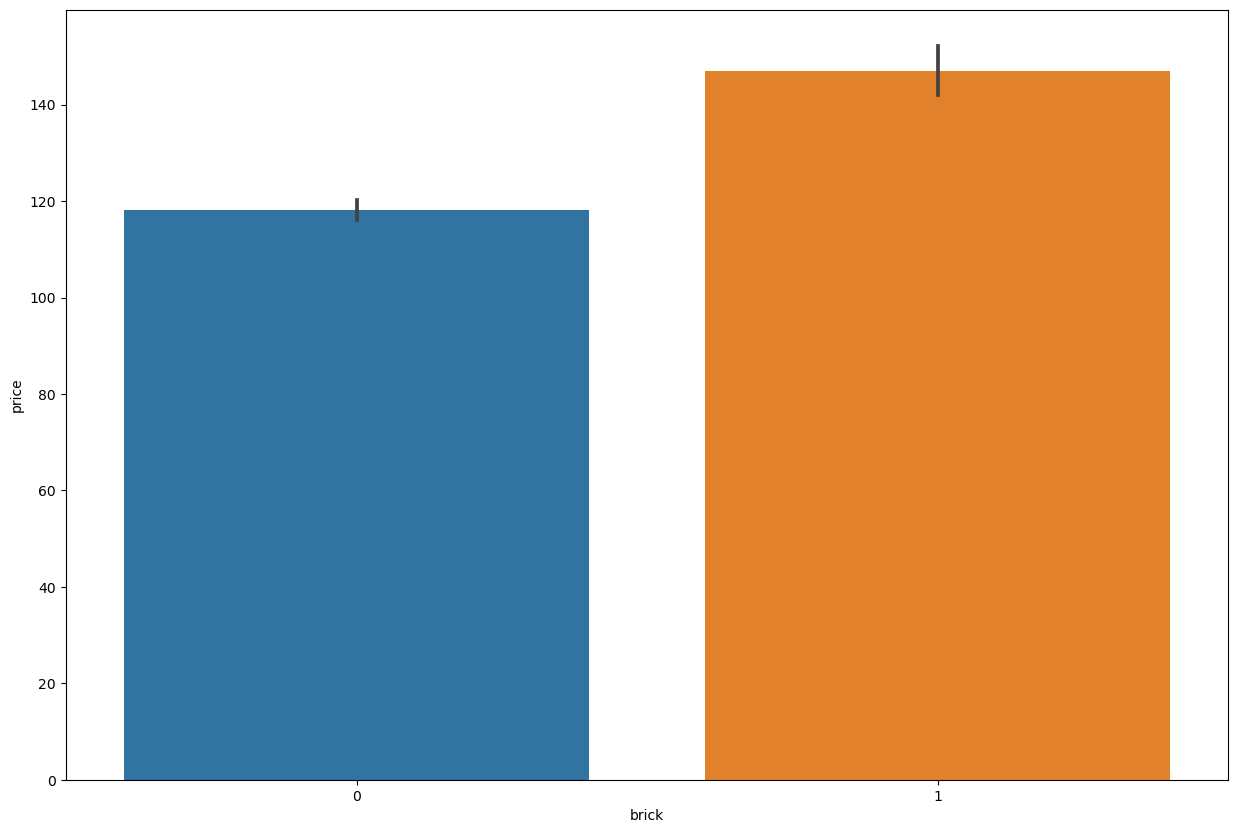

In [129]:
plt.figure(figsize=(15,10))
sns.barplot(x=df.brick, y=df.price)

<AxesSubplot:xlabel='brick', ylabel='totsp'>

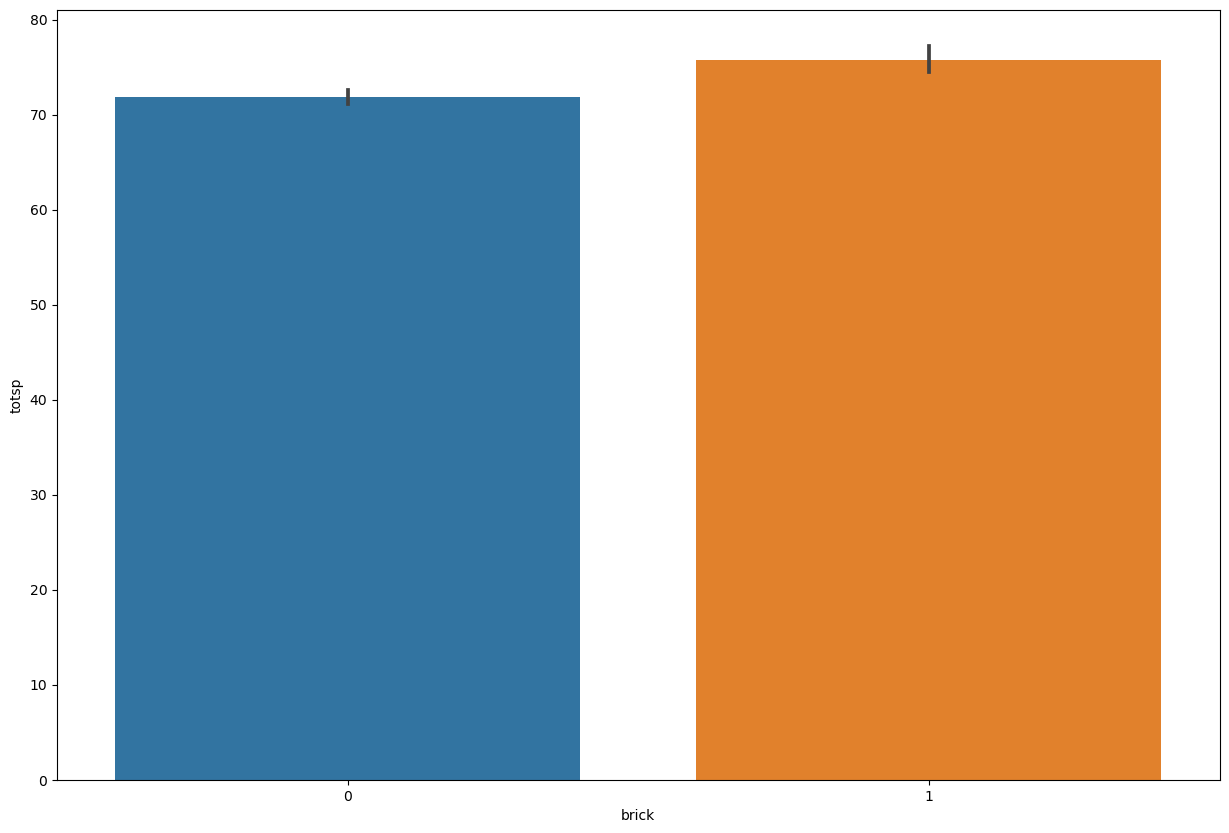

In [130]:
plt.figure(figsize=(15,10))
sns.barplot(x=df.brick, y=df.totsp)

Дома из кирпича/монолитного ж/б существенно дороже обычных

<AxesSubplot:xlabel='floor', ylabel='count'>

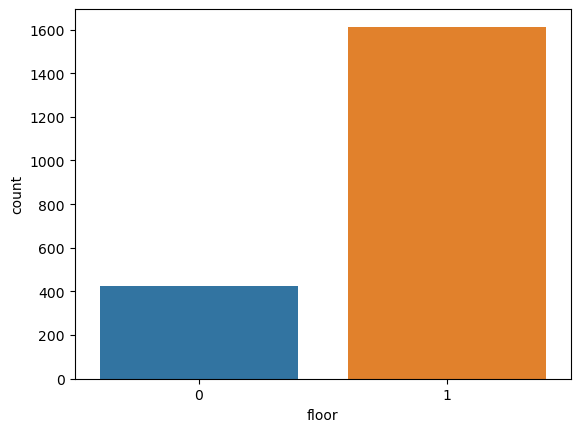

In [131]:
sns.countplot(data=df, x='floor')

<AxesSubplot:xlabel='floor', ylabel='price'>

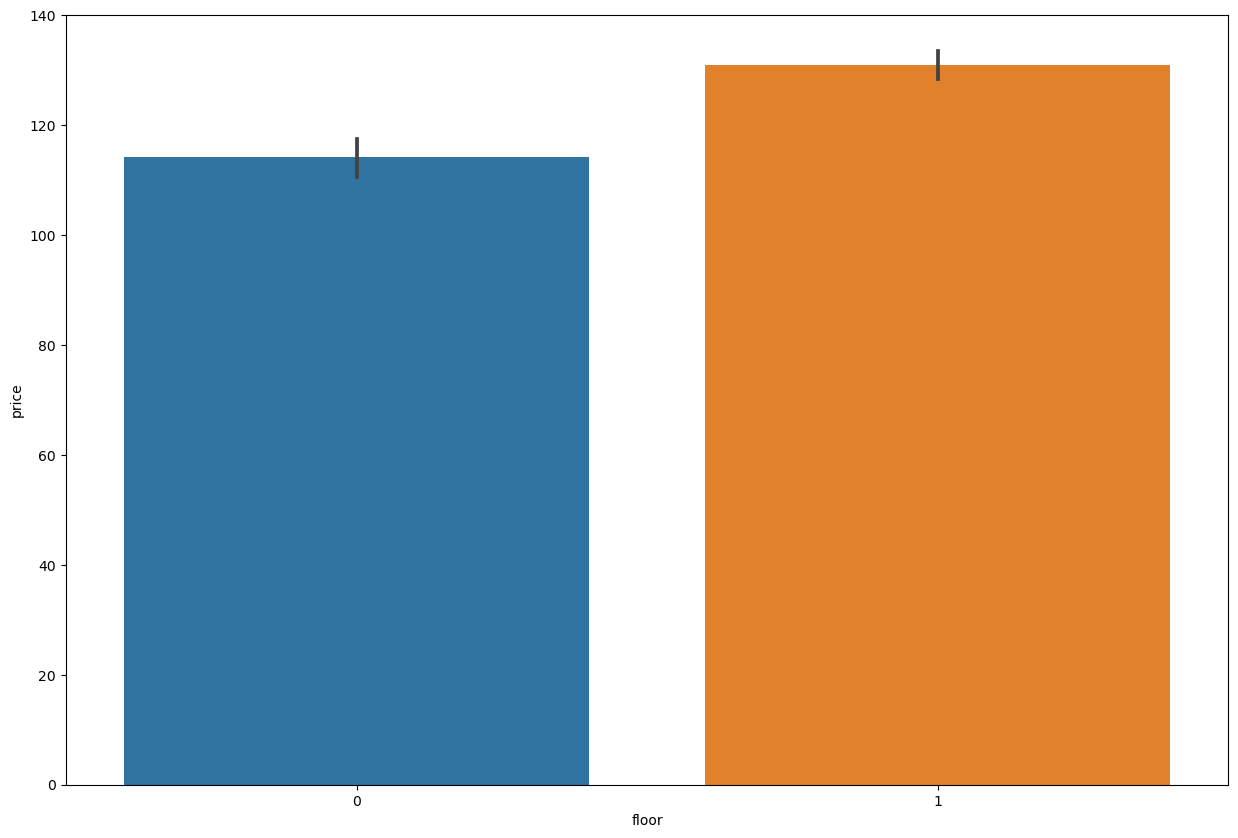

In [132]:
plt.figure(figsize=(15,10))
sns.barplot(x=df.floor, y=df.price)

<AxesSubplot:xlabel='floor', ylabel='totsp'>

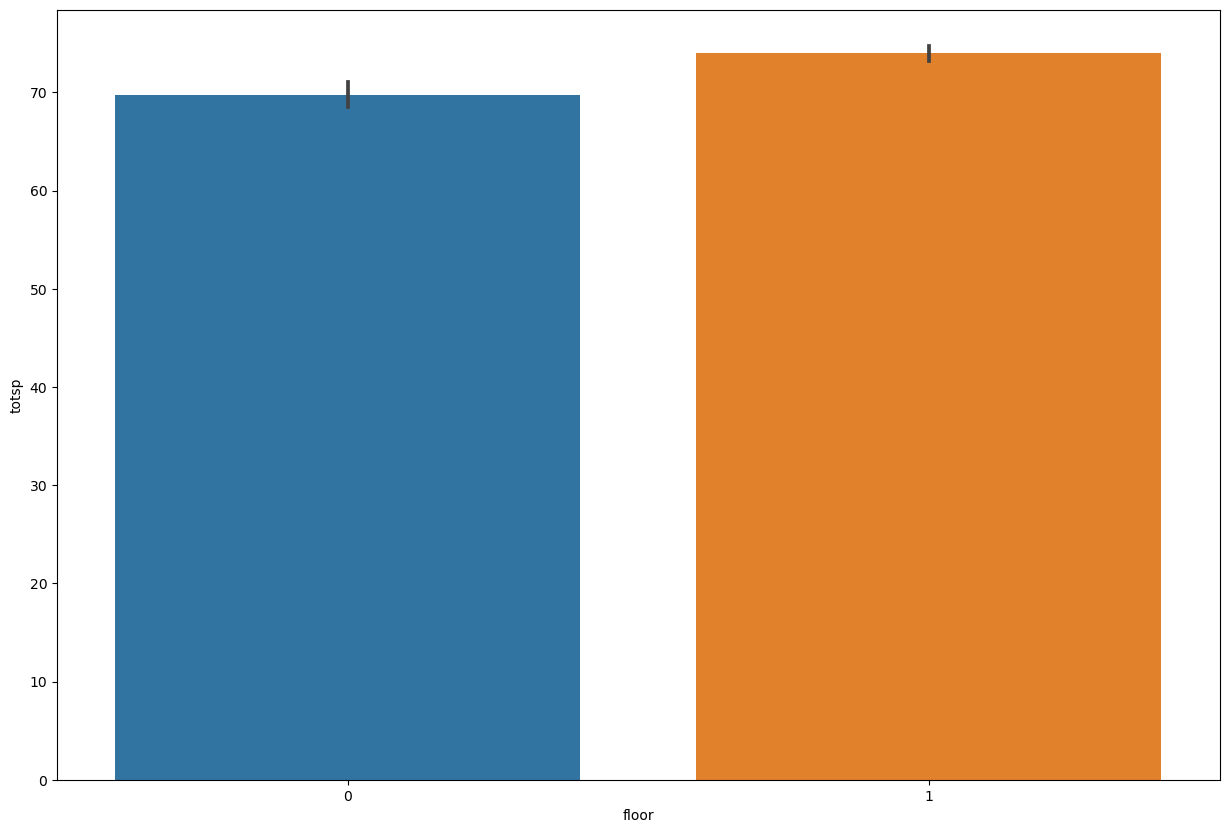

In [133]:
plt.figure(figsize=(15,10))
sns.barplot(x=df.floor, y=df.totsp)

Этаж уже меньше влияет на цену, однако зависимость все равно есть

<AxesSubplot:>

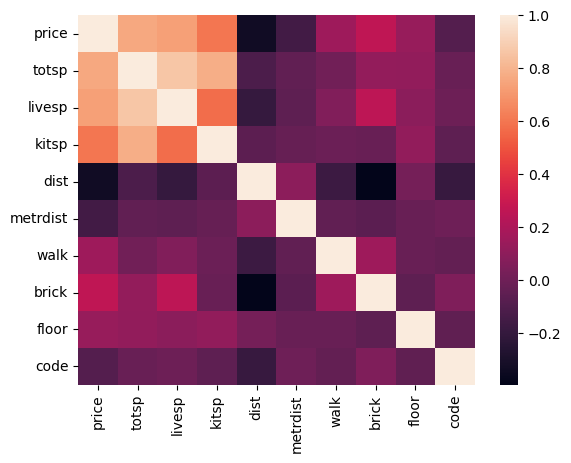

In [134]:
corr = df.corr()
sns.heatmap(corr)

# Сравнение моделей машинного обучения

In [135]:
X = df.drop(['price'], axis=1).values
Y = df['price'].values

test_size = 0.25
r_state = 123
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=r_state)

In [136]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)
probs = linear_regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))

MSE:  1414.8003514227987
MAE:  19.93765320500569
RMSE:  37.61383191623526
R2:  0.6580320454547784


In [161]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_train)
probs = rf_regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))

MSE:  1033.808040168691
MAE:  16.609545798319324
RMSE:  32.15288540969054
R2:  0.7501207710802704


In [138]:
tree_regressor = DecisionTreeRegressor()
tree_regressor.fit(X_train, y_train)
probs = tree_regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))

MSE:  1829.3063180827887
MAE:  21.71503267973856
RMSE:  42.7703906702147
R2:  0.5578428156295543


In [139]:
kn_regressor = KNeighborsRegressor()
kn_regressor.fit(X_train, y_train)
probs = kn_regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))

MSE:  1253.5619607843137
MAE:  18.976078431372546
RMSE:  35.405676957012325
R2:  0.6970045849974469


In [140]:
svr_regressor = SVR()
svr_regressor.fit(X_train, y_train)
probs = svr_regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))

MSE:  2740.56836028404
MAE:  25.351481968053584
RMSE:  52.35043801425199
R2:  0.33758388205431245


In [141]:
nn_regressor = MLPRegressor()
nn_regressor.fit(X_train, y_train)
probs = nn_regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))

MSE:  1332.6081358180945
MAE:  19.473155307926973
RMSE:  36.50490564044913
R2:  0.6778985261363917


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [142]:
xgb_regressor = XGBRegressor()
xgb_regressor.fit(X_train, y_train)
probs = xgb_regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))

MSE:  1231.6380583899145
MAE:  17.89168066884957
RMSE:  35.094701286517804
R2:  0.7023037581634148


Лучший результат показал случайный лес, дальше будем работать с ним

# Аномальные данные

Из boxplot видно несколько квартир которые сильно отличаются соотнешением размер/цена от остальных, попробуем рассмотреть их подробнее

In [153]:
df.query('price > 500')

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
966,730,134,102,10.0,9.0,10,1,1,1,4
1656,530,150,80,15.0,7.5,7,1,1,1,3


In [154]:
df.query('totsp > 180')

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
624,455,192,92,18.0,7.5,5,1,0,1,3


In [155]:
df.query('livesp > 90')

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
624,455,192,92,18.0,7.5,5,1,0,1,3
966,730,134,102,10.0,9.0,10,1,1,1,4
1528,477,119,93,15.0,9.0,1,1,0,1,3


In [156]:
df.query('kitsp > 22.5')

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
520,190,106,58,24.0,9.0,5,0,0,1,4
667,240,105,55,23.0,10.0,5,1,0,1,6
1119,252,132,74,23.0,12.5,3,1,1,0,3
1126,153,80,40,25.0,10.5,10,0,0,1,3
1684,145,76,44,24.0,12.7,2,1,0,0,5


In [157]:
df.query('metrdist > 17.5')

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
67,100,78,44,8.0,13.5,20,0,0,1,1
174,50,63,47,7.0,12.0,20,0,1,0,7
245,225,101,65,15.0,10.5,20,1,1,1,3
349,123,79,45,13.0,9.0,20,1,0,1,4
521,132,84,52,11.0,12.7,20,1,0,1,5
550,107,65,39,8.0,12.5,20,1,0,1,2
690,100,78,44,9.0,13.5,20,0,0,1,1
913,110,71,43,10.0,14.5,20,0,0,1,3
1005,100,72,42,10.0,14.5,20,0,0,0,3
1608,112,66,44,7.0,8.0,20,1,0,1,1


<AxesSubplot:xlabel='totsp', ylabel='price'>

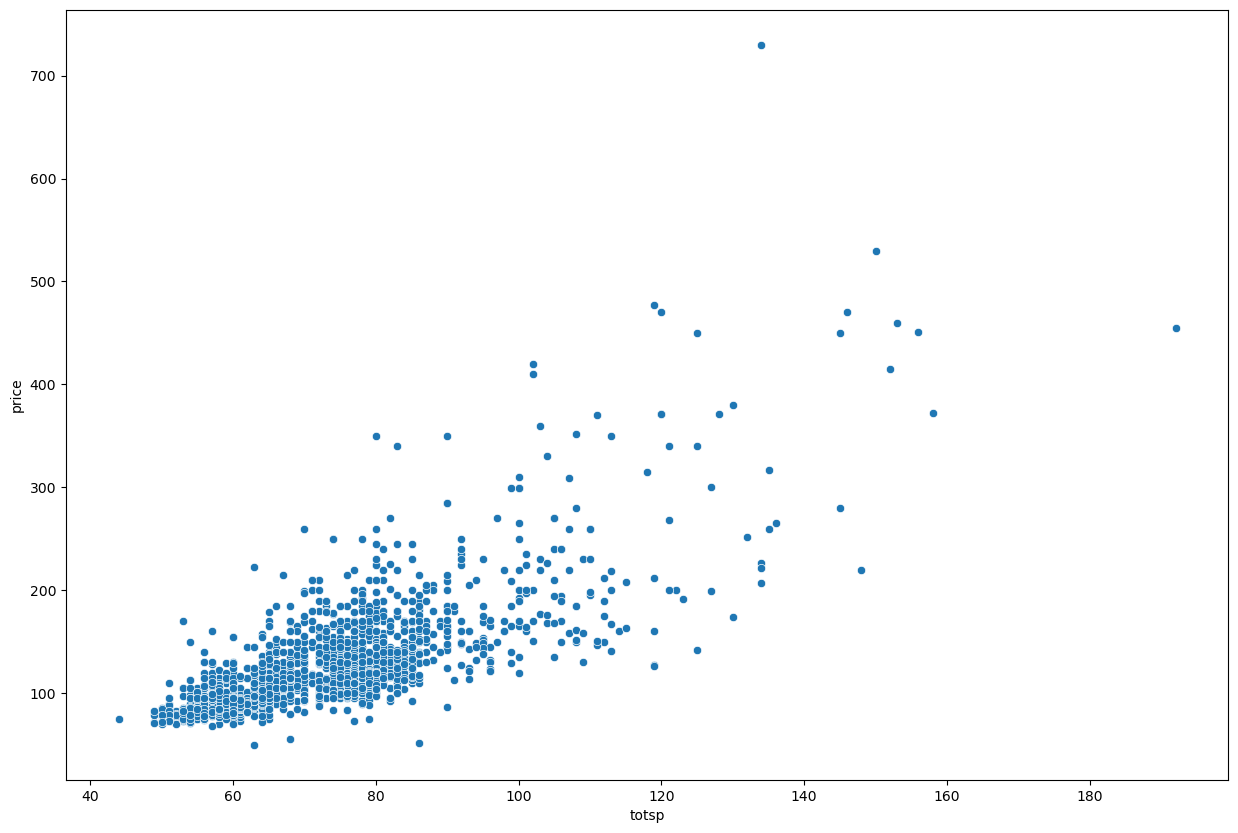

In [158]:
plt.figure(figsize=(15,10))
sns.scatterplot(x=df.totsp, y=df.price)

In [159]:
df.drop(index = [624, 966], inplace = True)
df.shape

(2038, 10)

# Результаты после

In [160]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)
probs = linear_regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))

MSE:  1414.8003514227987
MAE:  19.93765320500569
RMSE:  37.61383191623526
R2:  0.6580320454547784


In [137]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_train)
probs = rf_regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))

MSE:  1000.9853992122871
MAE:  16.537959383753503
RMSE:  31.638353294890162
R2:  0.7580542518567954


In [162]:
tree_regressor = DecisionTreeRegressor()
tree_regressor.fit(X_train, y_train)
probs = tree_regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))

MSE:  2050.270043572985
MAE:  22.86013071895425
RMSE:  45.279907724872686
R2:  0.5044342105506933


In [163]:
kn_regressor = KNeighborsRegressor()
kn_regressor.fit(X_train, y_train)
probs = kn_regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))

MSE:  1253.5619607843137
MAE:  18.976078431372546
RMSE:  35.405676957012325
R2:  0.6970045849974469


In [164]:
svr_regressor = SVR()
svr_regressor.fit(X_train, y_train)
probs = svr_regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))

MSE:  2740.56836028404
MAE:  25.351481968053584
RMSE:  52.35043801425199
R2:  0.33758388205431245


In [165]:
nn_regressor = MLPRegressor()
nn_regressor.fit(X_train, y_train)
probs = nn_regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))

MSE:  1280.625606692762
MAE:  18.999438122879198
RMSE:  35.78582969127252
R2:  0.6904630969178454


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [166]:
xgb_regressor = XGBRegressor()
xgb_regressor.fit(X_train, y_train)
probs = xgb_regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))

MSE:  1231.6380583899145
MAE:  17.89168066884957
RMSE:  35.094701286517804
R2:  0.7023037581634148


# Добавление новых признаков

In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2038 entries, 0 to 2039
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   price     2038 non-null   int64  
 1   totsp     2038 non-null   int64  
 2   livesp    2038 non-null   int64  
 3   kitsp     2038 non-null   float64
 4   dist      2038 non-null   float64
 5   metrdist  2038 non-null   int64  
 6   walk      2038 non-null   int64  
 7   brick     2038 non-null   int64  
 8   floor     2038 non-null   int64  
 9   code      2038 non-null   int64  
dtypes: float64(2), int64(8)
memory usage: 175.1 KB


In [168]:
df_ft = df.copy()

In [169]:
X = df_ft.drop(['price'], axis=1).values
Y = df_ft['price'].values

test_size = 0.25
r_state = 123
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=r_state)

In [170]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_train)
probs = rf_regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))

MSE:  476.04333618852763
MAE:  14.026035014005602
RMSE:  21.818417362139897
R2:  0.7502336477543496


In [171]:
def code_map(code):
    if code == 2:
        return 0
    elif code == 5:
        return 0
    elif code == 6:
        return 0
    elif code == 7:
        return 0
    else:
        return 1
 
df_ft['good_neighbourhood'] = df_ft['code'].map(code_map)
display(df_ft.head())

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code,good_neighbourhood
0,81,58,40,6.0,12.5,7,1,1,1,3,1
1,75,44,28,6.0,13.5,7,1,0,1,6,0
2,128,70,42,6.0,14.5,3,1,1,1,3,1
3,95,61,37,6.0,13.5,7,1,0,1,1,1
4,330,104,60,11.0,10.5,7,0,1,1,3,1


In [172]:
X = df_ft.drop(['price'], axis=1).values
Y = df_ft['price'].values

test_size = 0.25
r_state = 123
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=r_state)

In [173]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_train)
probs = rf_regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))

MSE:  481.35181306273523
MAE:  14.021150108932462
RMSE:  21.939731380824497
R2:  0.7474484414421114


In [174]:
df_ft.drop('code', axis = 1, inplace = True)
df_ft.head()

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,good_neighbourhood
0,81,58,40,6.0,12.5,7,1,1,1,1
1,75,44,28,6.0,13.5,7,1,0,1,0
2,128,70,42,6.0,14.5,3,1,1,1,1
3,95,61,37,6.0,13.5,7,1,0,1,1
4,330,104,60,11.0,10.5,7,0,1,1,1


In [175]:
X = df_ft.drop(['price'], axis=1).values
Y = df_ft['price'].values

test_size = 0.25
r_state = 123
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=r_state)

In [176]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_train)
probs = rf_regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))

MSE:  519.9235467205315
MAE:  14.487022550434315
RMSE:  22.801832091315195
R2:  0.7272109536271718


In [177]:
df_ft = df.copy()

In [178]:
df_ft.drop('metrdist', axis = 1, inplace = True)
df_ft.head()
X = df_ft.drop(['price'], axis=1).values
Y = df_ft['price'].values

test_size = 0.25
r_state = 123
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=r_state)

In [179]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_train)
probs = rf_regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))

MSE:  487.4458876642095
MAE:  14.287921241830066
RMSE:  22.078176728711306
R2:  0.7442510544232953


In [180]:
df_ft = df.copy()

In [181]:
def center_map(dist):
    if dist > 9:
        return 0
    else:
        return 1
 
df_ft['close_to_center'] = df_ft['dist'].map(center_map)
df_ft.head()

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code,close_to_center
0,81,58,40,6.0,12.5,7,1,1,1,3,0
1,75,44,28,6.0,13.5,7,1,0,1,6,0
2,128,70,42,6.0,14.5,3,1,1,1,3,0
3,95,61,37,6.0,13.5,7,1,0,1,1,0
4,330,104,60,11.0,10.5,7,0,1,1,3,0


In [182]:
X = df_ft.drop(['price'], axis=1).values
Y = df_ft['price'].values

test_size = 0.25
r_state = 123
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=r_state)

In [183]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_train)
probs = rf_regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))

MSE:  470.5663054168403
MAE:  13.954591566929802
RMSE:  21.692540317280507
R2:  0.7531072894860759


In [184]:
df_ft = df.copy()

In [185]:
def totsp_map(totsp):
    if totsp < 60:
        return 1
    if totsp > 90:
        return 3
    else:
        return 2
 
df_ft['size'] = df_ft['totsp'].map(totsp_map)
df_ft.head()

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code,size
0,81,58,40,6.0,12.5,7,1,1,1,3,1
1,75,44,28,6.0,13.5,7,1,0,1,6,1
2,128,70,42,6.0,14.5,3,1,1,1,3,2
3,95,61,37,6.0,13.5,7,1,0,1,1,2
4,330,104,60,11.0,10.5,7,0,1,1,3,3


In [186]:
X = df_ft.drop(['price'], axis=1).values
Y = df_ft['price'].values

test_size = 0.25
r_state = 123
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=r_state)

In [187]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_train)
probs = rf_regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))

MSE:  471.44800764882064
MAE:  13.863392857142857
RMSE:  21.712853512351174
R2:  0.7526446854886923


# Кодирование данных

std = StandardScaler()
df[num_cols] = std.fit_transform(df[num_cols])

In [188]:
mapp = {}
label_encoder = LabelEncoder()
for col in bin_cols:
    df[col] = label_encoder.fit_transform(df[col])
    mapp[col] = dict(enumerate(label_encoder.classes_))

In [189]:
mappc = {}
enc = OneHotEncoder()
for col in cat_cols:
    df[col] = label_encoder.fit_transform(df[col])
    mappc[col] = dict(enumerate(label_encoder.classes_))

In [190]:
df = pd.get_dummies(df, prefix=cat_cols, columns=cat_cols)

In [191]:
df.head()

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code_0,code_1,code_2,code_3,code_4,code_5,code_6,code_7
0,81,58,40,6.0,12.5,7,1,1,1,0,0,1,0,0,0,0,0
1,75,44,28,6.0,13.5,7,1,0,1,0,0,0,0,0,1,0,0
2,128,70,42,6.0,14.5,3,1,1,1,0,0,1,0,0,0,0,0
3,95,61,37,6.0,13.5,7,1,0,1,1,0,0,0,0,0,0,0
4,330,104,60,11.0,10.5,7,0,1,1,0,0,1,0,0,0,0,0


In [192]:
X = df.drop(['price'], axis=1).values
Y = df['price'].values

test_size = 0.25
r_state = 123
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=r_state)

In [193]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_train)
probs = rf_regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))

MSE:  467.7120073296302
MAE:  13.805467447585094
RMSE:  21.6266503955104
R2:  0.7546048582309135


# Подбор параметров

In [194]:
params = {
         'n_estimators': range(1, 200),
         'max_depth': range(1, 30),
         'min_samples_split': range(2, 30),
         'min_samples_leaf': range(1, 30)
         }         

In [230]:
random_search = RandomizedSearchCV(rf_regressor, param_distributions=params, cv = 10, n_iter = 500, 
                                   scoring='r2', n_jobs=-1, verbose=3, random_state=123)

random_search.fit(X_train, y_train)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits


RandomizedSearchCV(cv=10,
                   estimator=RandomForestRegressor(max_depth=27,
                                                   min_samples_leaf=3,
                                                   min_samples_split=6,
                                                   n_estimators=73),
                   n_iter=500, n_jobs=-1,
                   param_distributions={'max_depth': range(1, 30),
                                        'min_samples_leaf': range(1, 30),
                                        'min_samples_split': range(2, 30),
                                        'n_estimators': range(1, 200)},
                   random_state=123, scoring='r2', verbose=3)

In [196]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
#print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)


 All results:
{'mean_fit_time': array([0.10049129, 0.37874365, 0.33590488, 0.18456755, 0.39776106,
       0.33810673, 0.23241091, 0.08567791, 0.23841653, 0.26063662,
       0.0466423 , 0.11250219, 0.36052718, 0.21519532, 0.48964458,
       0.02222023, 0.12551394, 0.36413059, 0.0658597 , 0.02302098,
       0.10549588, 0.3124835 , 0.20518622, 0.44804559, 0.22811832,
       0.07426748, 0.11634469, 0.41903582, 0.44600482, 0.22880783,
       0.26724248, 0.21979952, 0.23581414, 0.1683527 , 0.2370153 ,
       0.05364852, 0.39656   , 0.15193796, 0.0862783 , 0.30307522,
       0.13412175, 0.3520227 , 0.17876225, 0.23831944, 0.20088525,
       0.19707966, 0.07767029, 0.04584136, 0.34491301, 0.0982892 ,
       0.12391238, 0.11230187, 0.47463098, 0.2966691 , 0.07446756,
       0.0350317 , 0.01281157, 0.29406672, 0.29406691, 0.31048169,
       0.37654171, 0.30687847, 0.27845283, 0.38798909, 0.35689373,
       0.04484076, 0.50597439, 0.07070117, 0.31613522, 0.222018  ,
       0.41860991, 0.07867141

In [197]:
X = df.drop(['price'], axis=1).values
Y = df['price'].values

test_size = 0.25
r_state = 123
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=r_state)

In [229]:
probs = random_search.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))

MSE:  534.5408416286476
MAE:  14.712670662390241
RMSE:  23.120139308158322
R2:  0.7195416761657323


In [319]:
rf_regressor = RandomForestRegressor(n_estimators= 12, min_samples_split= 2, min_samples_leaf= 4, max_depth= 13)
rf_regressor.fit(X_train, y_train)
probs = rf_regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))

MSE:  527.9519288317227
MAE:  14.694695833218969
RMSE:  22.97720454780613
R2:  0.7229986906630446


In [311]:
rf_regressor = RandomForestRegressor(n_estimators = 73, min_samples_split = 6, min_samples_leaf = 3, max_depth = 27)
rf_regressor.fit(X_train, y_train)
probs = rf_regressor.predict(X_test)
print('MSE: ', mean_squared_error(y_test, probs))
print('MAE: ', mean_absolute_error(y_test, probs))
print('RMSE: ', math.sqrt(mean_squared_error(y_test, probs)))
print('R2: ', r2_score(y_test, probs))

MSE:  479.29051048858673
MAE:  13.99036544262163
RMSE:  21.892704503751627
R2:  0.748529948073297


# Предсказание цены

In [200]:
flat2 = df.iloc[2]
flat2

price       128.0
totsp        70.0
livesp       42.0
kitsp         6.0
dist         14.5
metrdist      3.0
walk          1.0
brick         1.0
floor         1.0
code_0        0.0
code_1        0.0
code_2        1.0
code_3        0.0
code_4        0.0
code_5        0.0
code_6        0.0
code_7        0.0
Name: 2, dtype: float64

In [201]:
flat122 = df.iloc[122]
flat122

price       190.0
totsp        81.0
livesp       46.0
kitsp        12.0
dist         12.0
metrdist      5.0
walk          0.0
brick         0.0
floor         1.0
code_0        0.0
code_1        0.0
code_2        0.0
code_3        0.0
code_4        0.0
code_5        0.0
code_6        0.0
code_7        1.0
Name: 122, dtype: float64

In [202]:
flat555 = df.iloc[555]
flat555

price       95.0
totsp       64.0
livesp      45.0
kitsp        6.0
dist        12.5
metrdist    10.0
walk         1.0
brick        0.0
floor        1.0
code_0       0.0
code_1       1.0
code_2       0.0
code_3       0.0
code_4       0.0
code_5       0.0
code_6       0.0
code_7       0.0
Name: 555, dtype: float64

In [203]:
flat98 = df.iloc[98]
flat98

price       208.0
totsp       115.0
livesp       70.0
kitsp        14.0
dist         10.0
metrdist      3.0
walk          1.0
brick         1.0
floor         1.0
code_0        0.0
code_1        0.0
code_2        0.0
code_3        0.0
code_4        0.0
code_5        1.0
code_6        0.0
code_7        0.0
Name: 98, dtype: float64

In [204]:
flat25 = df.iloc[25]
flat25

price       56.0
totsp       68.0
livesp      43.0
kitsp        7.0
dist        13.5
metrdist    10.0
walk         0.0
brick        1.0
floor        1.0
code_0       0.0
code_1       0.0
code_2       0.0
code_3       0.0
code_4       0.0
code_5       1.0
code_6       0.0
code_7       0.0
Name: 25, dtype: float64

In [205]:
df.drop(index = [25, 98, 555, 122, 2], inplace = True)
df.shape

(2033, 17)

In [148]:
flat2.drop(index = "price", inplace = True)
y_pred = rf_regressor.predict(flat2.array.reshape(1, -1))
print('Recommended price of your flat:', y_pred[0])

Recommended price of your flat: 123.67


C:\Users\shadee\AppData\Local\Temp\ipykernel_8760\2908433146.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flat2.drop(index = "price", inplace = True)


In [149]:
flat122.drop(index = "price", inplace = True)
y_pred = rf_regressor.predict(flat122.array.reshape(1, -1))
print('Recommended price of your flat:', y_pred[0])

Recommended price of your flat: 179.7


C:\Users\shadee\AppData\Local\Temp\ipykernel_8760\4024058752.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flat122.drop(index = "price", inplace = True)


In [150]:
flat555.drop(index = "price", inplace = True)
y_pred = rf_regressor.predict(flat555.array.reshape(1, -1))
print('Recommended price of your flat:', y_pred[0])

Recommended price of your flat: 94.98


C:\Users\shadee\AppData\Local\Temp\ipykernel_8760\4249353670.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flat555.drop(index = "price", inplace = True)


In [151]:
flat98.drop(index = "price", inplace = True)
y_pred = rf_regressor.predict(flat98.array.reshape(1, -1))
print('Recommended price of your flat:', y_pred[0])

Recommended price of your flat: 206.93


C:\Users\shadee\AppData\Local\Temp\ipykernel_8760\3089167550.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flat98.drop(index = "price", inplace = True)


In [152]:
flat25.drop(index = "price", inplace = True)
y_pred = rf_regressor.predict(flat25.array.reshape(1, -1))
print('Recommended price of your flat:', y_pred[0])

Recommended price of your flat: 71.62


C:\Users\shadee\AppData\Local\Temp\ipykernel_8760\178397140.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flat25.drop(index = "price", inplace = True)
